---
title: "Missing data imputation for UK Biobank"
author: "Saikat Banerjee"
format:
  html: default
date: "2024-02-28"
file-modified: "2024-02-28"
abstract: "We hold out (mask) some of the data points, and then apply the methods to obtain estimates of the missing values."

---

In [64]:
import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

from scipy.cluster import hierarchy as sp_hierarchy

import sys
sys.path.append("../utils/")
import plot_functions as mpy_plotfn

In [24]:
def get_masked_rmse(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    mse = np.sum(np.square((original - recovered) * mask)) / np.sum(mask)
    return np.sqrt(mse)

In [2]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
h2_cut = 0.1
pval_cut = 5e-8

zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_h2{h2_cut}_pval{pval_cut}.pkl"))
trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_h2{h2_cut}.pkl"))

# Read masked data

In [4]:
dscout_dir = "/gpfs/commons/groups/knowles_lab/sbanerjee/low_rank_matrix_approximation_numerical_experiments/panukb"

data_filename = os.path.join(dscout_dir, f"ukbb/ukbb_1.pkl")
    
with (open(data_filename, "rb")) as fh:
    data = pickle.load(fh)

In [28]:
X = np.array(zscore_df.values.T)
#X_cent = X - np.mean(X, axis = 0, keepdims = True)
X_cent = data['Ztrue']
Z_cent = data['Z']
Z_mask = data['Zmask']

print (f"We have {X_cent.shape[0]} samples (phenotypes) and {X_cent.shape[1]} features (variants)")
print (f"Fraction of Nan entries: {np.sum(np.isnan(X)) / np.prod(X_cent.shape):.3f}")
print (f"Fraction of masked entries: {np.sum(Z_mask) / np.prod(X_cent.shape):.3f}")

zero_rmse = get_masked_rmse(X_cent, np.zeros_like(X_cent), mask = Z_mask)
print (f"RMSE of zero prediction: {zero_rmse}")

We have 216 samples (phenotypes) and 48212 features (variants)
Fraction of Nan entries: 0.000
Fraction of masked entries: 0.200
RMSE of zero prediction: 1.9950481725240365


In @fig-panukb-zscore-covariance we plot a heatmap from the covariance matrix of the Z-scores.

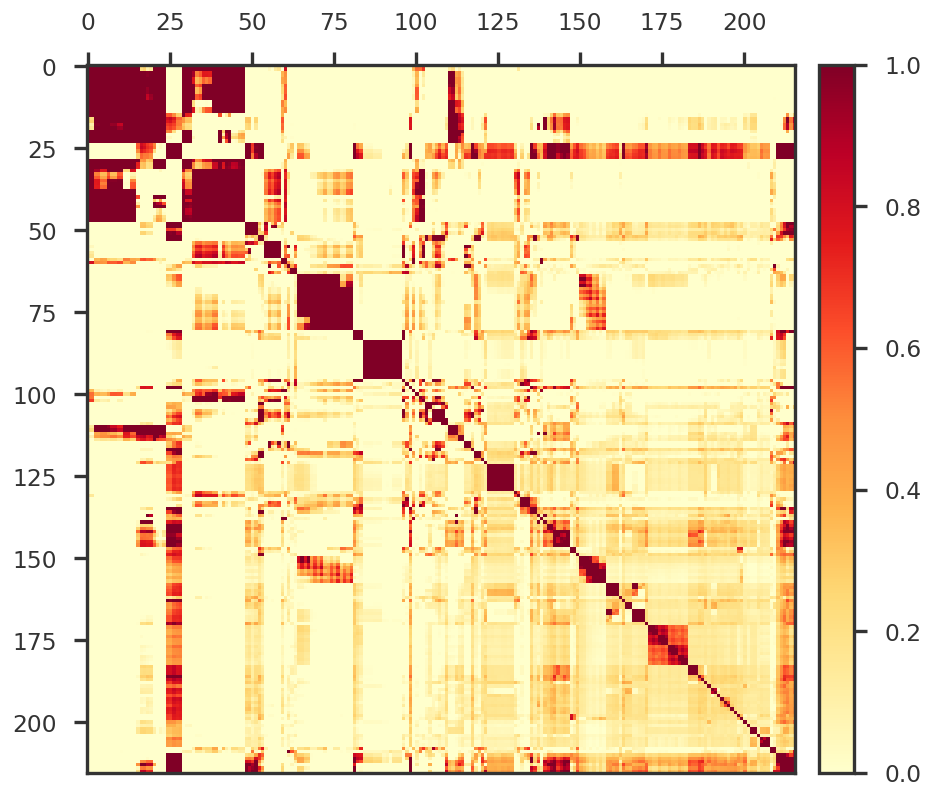

In [65]:
#| label: fig-panukb-zscore-covariance
#| fig-cap: "Covariance of Z-scores in PanUKB data"

o1 = sp_hierarchy.leaves_list(sp_hierarchy.linkage(np.cov(X_cent), method = 'centroid'))

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

mpy_plotfn.plot_covariance_heatmap(ax1, X_cent[o1, :])

plt.tight_layout()
plt.show()

In [25]:
method_labels = {
    "rpca" : "RPCA-IALM",
    "nnm" : "NN-FW",
    "nnm_sparse" : "NN-Sparse-FW",
    "truncated_svd": "tSVD",
    "factorgo": "FactorGO",
}

method_colors = {
    "rpca" : '#FF6800', # Vivid Orange
    "nnm" : '#C10020', # Vivid Red
    "nnm_sparse" : '#803E75', # Strong Purple
    "truncated_svd" : '#535154', # gray
    "factorgo" : '#A6BDD7', # Very Light Blue
}

optimum_rmse = dict()

# Read RPCA results

In [26]:
rpca_filename = os.path.join(dscout_dir, f"rpca/ukbb_1_rpca_1.pkl")
    
with (open(rpca_filename, "rb")) as fh:
    rpca_res = pickle.load(fh)
    
optimum_rmse['rpca'] = get_masked_rmse(X_cent, rpca_res['X'], mask = Z_mask)

To find the best possible lambda, we apply Robust PCA on the masked data with different values of $\lambda$. The RMSE of the recovered values
is shown in @fig-rpca-cv-lambda. As currently implemented, Robust PCA fails to recover the masked data and the RMSE is comparable to that from zero entries.

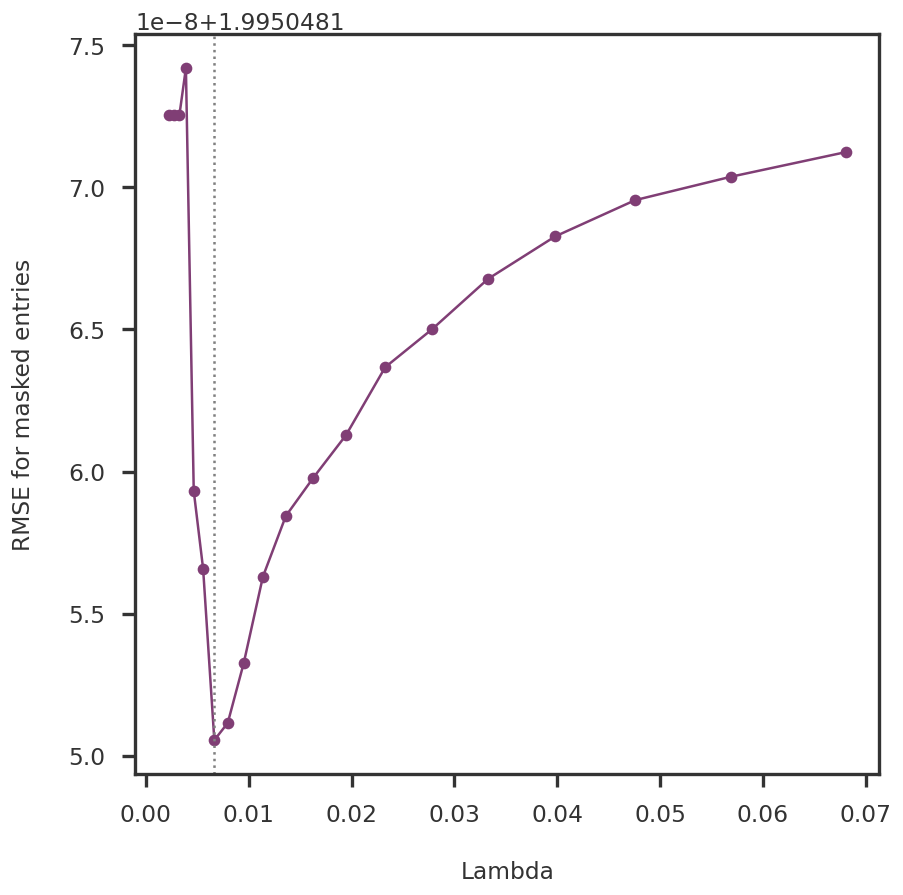

In [23]:
#| label: fig-rpca-cv-lambda
#| fig-cap: "RMSE of recovered values of masked entries in the PanUKB data"

fig = plt.figure()
ax1 = fig.add_subplot(111)

_optlmb = rpca_res['cvlmb'][np.argmin(rpca_res['cvrmse'])]

ax1.plot(rpca_res['cvlmb'], rpca_res['cvrmse'], marker = 'o')
ax1.axvline(x = _optlmb, ls = 'dotted', color = 'grey')
ax1.set_xlabel("Lambda")
ax1.set_ylabel("RMSE for masked entries")
plt.show()

# Read NNM results

In [56]:
nnm_filename = os.path.join(dscout_dir, f"nnm/ukbb_1_nnm_1.pkl")
    
with (open(nnm_filename, "rb")) as fh:
    nnm_res = pickle.load(fh)

For NNM, we consider the input as an incomplete data matrix. We perform a 2-fold cross-validation on the incomplete input data and show the RMSE for the CV and the RMSE for the cross-validation is shown in @fig-nnm-cv-rank.

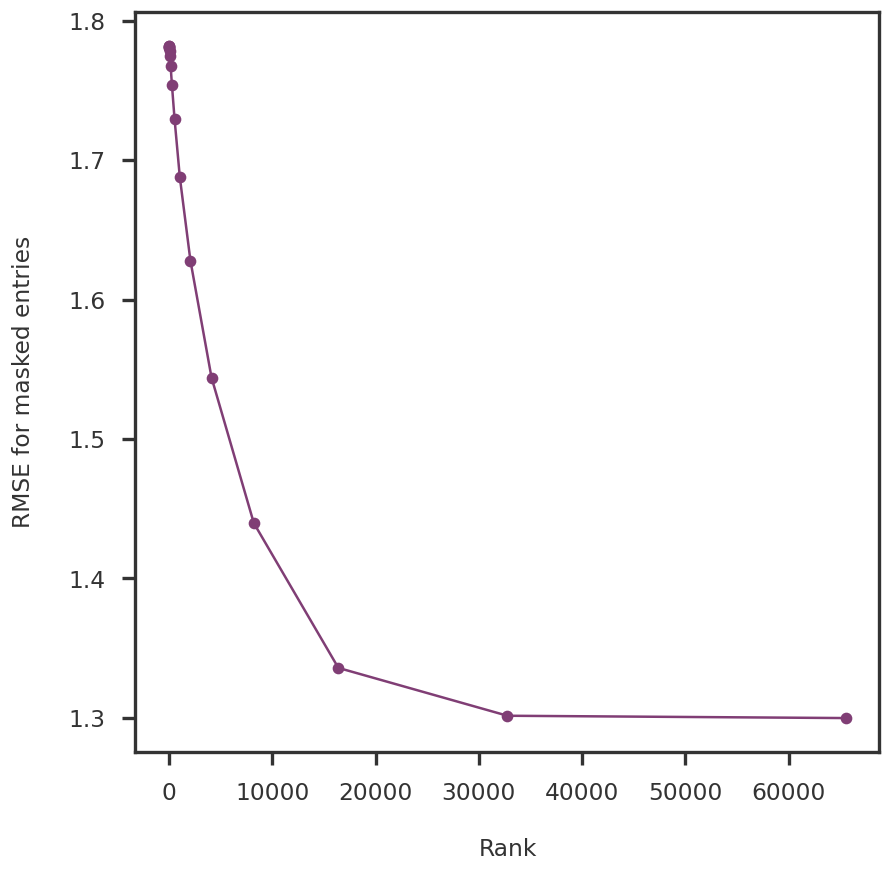

In [63]:
#| label: fig-nnm-cv-rank
#| fig-cap: "RMSE for recovery of hold-out test data"

fig = plt.figure()
ax1 = fig.add_subplot(111)

nnm_cvres = nnm_res['model']['test_error']

ax1.plot(nnm_cvres.keys(), [np.mean(x) for x in nnm_cvres.values()], marker = 'o')
ax1.set_xlabel("Rank")
ax1.set_ylabel("Cross validation RMSE")
plt.show()